In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchmetrics import ConfusionMatrix
from tqdm import tqdm
torch.__version__

'2.8.0+cpu'

In [5]:
DATASET_PATH = "../dataset/UTSCdataset"
LABELS = ["Haze", "Normal", "Smoke"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cpu')

Image shape: torch.Size([3, 256, 256])
Pixel range: [0.0-1.0]


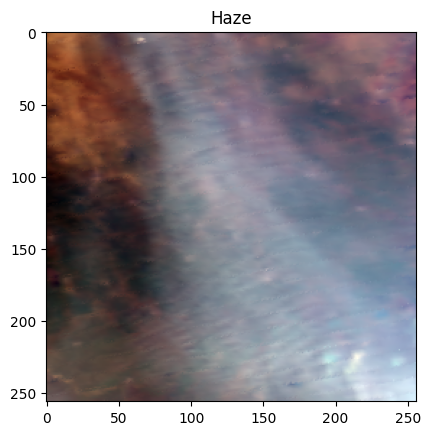

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dset = ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_transform)
test_dset = ImageFolder(os.path.join(DATASET_PATH, "test"), transform=train_transform)

image, label_index = train_dset[0]
print("Image shape:", image.shape)
print(f"Pixel range: [{image.min()}-{image.max()}]")

# (H, W, C) for matplotlib
plt.title(LABELS[label_index]) #train_dset.class_to_idx -> {'haze': 0, 'normal': 1, 'smoke': 2}
plt.imshow(image.permute(1, 2, 0))

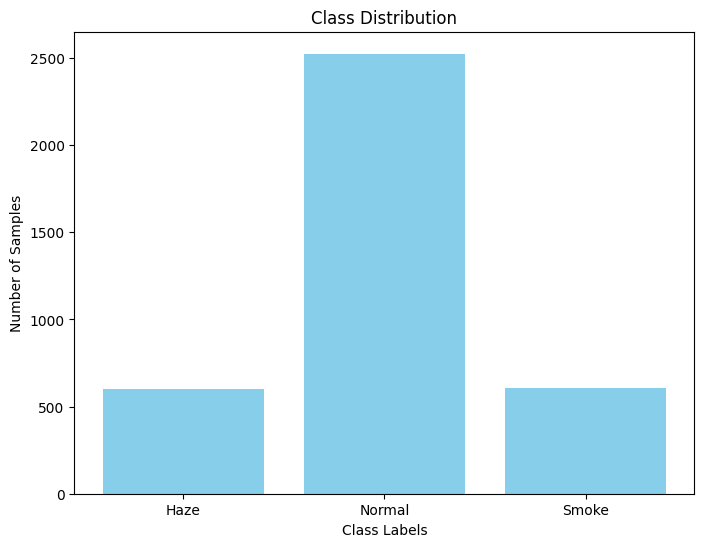

In [7]:
def plot_class_distribution(dataset, labels):
    class_counts = [0] * len(labels)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(8, 6))
    plt.bar(labels, class_counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.show()

# Example usage:
plot_class_distribution(train_dset, LABELS)

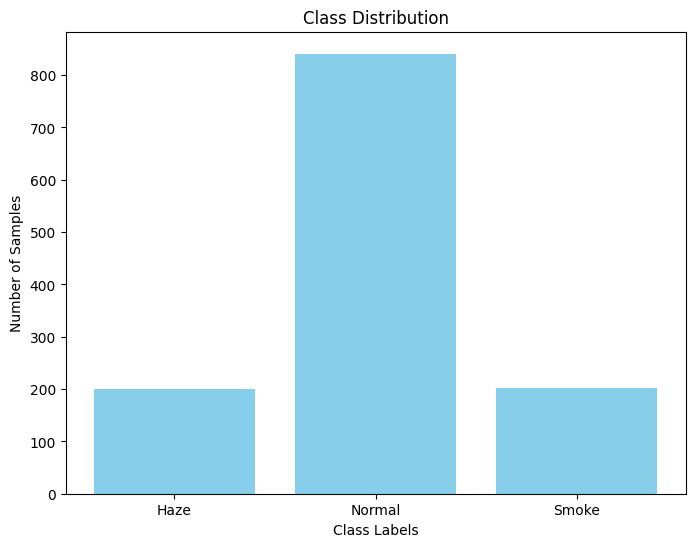

In [8]:
plot_class_distribution(test_dset, LABELS)

In [4]:
class BasicCNNModule(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        return self.relu(x)
    

class BasicCNN(nn.Module):
    def __init__(self, in_channels=3, hdim=64, num_classes=3, input_size=256):
        super().__init__()
        # 5 layers of conv with downsampling each spatial dimension by factor of 1/2 while
        # doubling the channels
        self.conv_modules = nn.ModuleList(
            [BasicCNNModule(in_channels=in_channels, out_channels=hdim, kernel_size=3, stride=1, padding=1)]
            + [BasicCNNModule(
                in_channels=hdim * (2**i), 
                out_channels=hdim * (2**(i+1)), 
                kernel_size=3, 
                stride=1, 
                padding=1) for i in range(4)
            ]
        )
        final_features = int((input_size * input_size) * hdim * (2 ** 4) / (2 ** 10))
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(in_features=final_features, out_features=num_classes)

    def forward(self, x):
        for module in self.conv_modules:
            x = module(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
        
cnn = BasicCNN()
x = torch.randn(1, 3, 256, 256)
print(cnn(x).shape)

torch.Size([1, 3])


In [20]:
"""Basic from scratch CNN"""
class BasicCNNModule(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, **kwargs)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.maxpool(x)
        return self.relu(x)
    

class BasicCNN(nn.Module):
    def __init__(self, in_channels=3, hdim=64, num_classes=3, input_size=256):
        super().__init__()
        # 5 layers of conv with downsampling each spatial dimension by factor of 1/2 while
        # doubling the channels
        self.conv_modules = nn.ModuleList(
            [BasicCNNModule(in_channels=in_channels, out_channels=hdim, kernel_size=3, stride=1, padding=1)]
            + [BasicCNNModule(
                in_channels=hdim * (2**i), 
                out_channels=hdim * (2**(i+1)), 
                kernel_size=3, 
                stride=1, 
                padding=1) for i in range(4)
            ]
        )
        final_features = int((input_size * input_size) * hdim * (2 ** 4) / (2 ** 10))
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(in_features=final_features, out_features=num_classes)

    def forward(self, x):
        for module in self.conv_modules:
            x = module(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

"""Fine tuning pretrained models from torchvision"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as tvm

# ----- VGG16Tuned ---------------------------------------------------------
class VGG16Tuned(nn.Module):
    """VGG16 edited for 3-class haze classification."""
    def __init__(self, num_classes=3, pretrained=True, freeze_features=True):
        super().__init__()
        base = tvm.vgg16(weights=tvm.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        if freeze_features:
            for p in base.features.parameters(): p.requires_grad = False
        # replace classifier output
        in_f = base.classifier[-1].in_features
        base.classifier[-1] = nn.Linear(in_f, num_classes)
        self.model = base
    def forward(self, x):
        return self.model(x)

for net in (BasicCNN(), VGG16Tuned()):
    cnn = net
    x = torch.randn(1, 3, 256, 256)
    print(net.__class__.__name__, end=": ")
    print(cnn(x).shape)

BasicCNN: torch.Size([1, 3])
VGG16Tuned: torch.Size([1, 3])


In [11]:
"""Attention modules"""
#----- default settings -----------------------------------------------------
class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c_in, c_out, k, s, p, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.block(x)

# ----- Haze-Aware Enhancement (HAE) ----------------------------------------
class HAEHead(nn.Module):
    """Predicts a 1-channel haze transmission map and compresses to a 128-D vector."""
    def __init__(self, in_ch=3, width=32, out_dim=128):
        super().__init__()
        self.body = nn.Sequential(
            ConvBNAct(in_ch, width),
            ConvBNAct(width, width),
            nn.Conv2d(width, 1, 1)
        )
        self.proj = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, out_dim))
    def forward(self, x):
        t = torch.sigmoid(self.body(x))                # transmission map
        pooled = F.adaptive_avg_pool2d(t, 1).view(x.size(0), 1)
        vec = self.proj(pooled)
        return vec, t

# ----- Dual-View Texture ----------------------------------------------------
class EdgeExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]],dtype=torch.float32)
        sobel_y = sobel_x.t()
        lap = torch.tensor([[0,1,0],[1,-4,1],[0,1,0]],dtype=torch.float32)
        self.register_buffer("kx", sobel_x[None,None])
        self.register_buffer("ky", sobel_y[None,None])
        self.register_buffer("kl", lap[None,None])
    @torch.no_grad()
    def forward(self, rgb):
        r,g,b = rgb[:,0:1], rgb[:,1:2], rgb[:,2:3]
        gray = 0.2989*r + 0.587*g + 0.114*b
        ex = F.conv2d(gray, self.kx, padding=1)
        ey = F.conv2d(gray, self.ky, padding=1)
        el = F.conv2d(gray, self.kl, padding=1)
        e = torch.cat([ex,ey,el],1)
        e = e/(e.abs().amax((2,3),keepdim=True)+1e-6)
        return e

class TextureHead(nn.Module):
    """Extracts structural cues from Sobel/Laplacian edge maps → 128-D vector."""
    def __init__(self, width=32, out_dim=128):
        super().__init__()
        self.edge = EdgeExtractor()
        self.fe = nn.Sequential(
            ConvBNAct(3,width),
            ConvBNAct(width,width*2),
            ConvBNAct(width*2,width*2)
        )
        self.proj = nn.Sequential(nn.Linear(width*2,out_dim), nn.ReLU(True))
    def forward(self, x):
        e = self.edge(x)
        f = self.fe(e)
        g = F.adaptive_avg_pool2d(f,1).flatten(1)
        vec = self.proj(g)
        return vec, e

# sanity
hae = HAEHead(); tex = TextureHead()
x = torch.randn(2,3,224,224)
v1,tmap = hae(x); v2,e = tex(x)
print("HAE vec/tmap:", v1.shape, tmap.shape)
print("Texture vec/edges:", v2.shape, e.shape)

HAE vec/tmap: torch.Size([2, 128]) torch.Size([2, 1, 224, 224])
Texture vec/edges: torch.Size([2, 128]) torch.Size([2, 3, 224, 224])


In [22]:
"""Utils for model wrapping"""
# === Model Builder Wrapper ==================================================
import torch.nn as nn
import torch.nn.functional as F

class FusionClassifier(nn.Module):
    def __init__(self, dim_backbone, dim_hae=128, dim_tex=128, num_classes=3, p_drop=0.2):
        super().__init__()
        dim_in = dim_backbone + (dim_hae if dim_hae else 0) + (dim_tex if dim_tex else 0)
        self.mlp = nn.Sequential(
            nn.LayerNorm(dim_in),
            nn.Linear(dim_in, 512), nn.ReLU(True),
            nn.Dropout(p_drop),
            nn.Linear(512, num_classes)
        )
    def forward(self, f_b, f_h=None, f_t=None):
        feats = [f_b]
        if f_h is not None: feats.append(f_h)
        if f_t is not None: feats.append(f_t)
        return self.mlp(torch.cat(feats, dim=1))


class ModelWithHeads(nn.Module):
    """Generic wrapper that adds HAE/Texture heads to any backbone producing a feature vector."""
    def __init__(self, backbone, feature_dim, num_classes=3, use_hae=True, use_tex=True):
        super().__init__()
        self.backbone = backbone
        self.use_hae = use_hae
        self.use_tex = use_tex
        self.hae = HAEHead(out_dim=128) if use_hae else None
        self.tex = TextureHead(out_dim=128) if use_tex else None
        self.cls = FusionClassifier(feature_dim,
                                    dim_hae=128 if use_hae else 0,
                                    dim_tex=128 if use_tex else 0,
                                    num_classes=num_classes)

    def forward(self, x):
        f_b = self.backbone(x)
        if f_b.ndim > 2:  # if feature map, pool and flatten
            f_b = F.adaptive_avg_pool2d(f_b, 1).flatten(1)
        f_h = f_t = None
        if self.use_hae: f_h, _ = self.hae(x)
        if self.use_tex: f_t, _ = self.tex(x)
        logits = self.cls(f_b, f_h, f_t)
        return logits
    
def build_model(model_name="basiccnn", use_heads=False, num_classes=3,
                pretrained=True, freeze_features=True):
    """
    Returns a model by name, optionally with HAE/Texture heads attached.
    model_name: 'basiccnn', 'vgg16'
    """
    model_name = model_name.lower()

    # --- baseline backbones ---
    if model_name == "basiccnn":
        backbone = BasicCNN(in_channels=3, hdim=64, num_classes=num_classes, input_size=256)
        feature_dim = num_classes  # BasicCNN outputs logits directly

    elif model_name == "vgg16":
        base = VGG16Tuned(num_classes=num_classes, pretrained=pretrained, freeze_features=freeze_features)
        # expose pre-classifier features instead of logits
        backbone = nn.Sequential(base.model.features, base.model.avgpool, nn.Flatten(), *list(base.model.classifier.children())[:-1])
        feature_dim = 4096

    
    else:
        raise ValueError("model_name must be one of: basiccnn, vgg16")

    # --- wrap or return plain ---
    if use_heads:
        return ModelWithHeads(backbone, feature_dim, num_classes=num_classes,
                              use_hae=True, use_tex=True)
    else:
        return backbone


In [21]:
"""test"""

# plain backbones
m1 = build_model("basiccnn", use_heads=False)
m2 = build_model("vgg16", use_heads=False)

# augmented versions
m1h = build_model("basiccnn", use_heads=True)
m2h = build_model("vgg16", use_heads=True)

# quick test
for name, model in [("basiccnn+heads", m1h), ("vgg16+heads", m2h)]:
    x = torch.randn(1,3,256,256)
    y = model(x)
    print(f"{name:15s} ->", tuple(y.shape))


basiccnn+heads  -> (1, 3)
vgg16+heads     -> (1, 3)


In [ ]:
train_loader = DataLoader(dataset=train_dset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dset, batch_size=32, shuffle=False)

data_batch = next(iter(train_loader))
imgs, labels = data_batch
imgs.shape, labels.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [63]:
@torch.no_grad()
def test_model(test_dataloader: DataLoader, model: nn.Module):
    # confusion matrix
    confmat = ConfusionMatrix(num_classes=3, task="multiclass").to(DEVICE)

    model.eval()
    model.to(DEVICE)
    for data_batch in tqdm(test_dataloader):
        imgs, labels = data_batch
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        confmat.update(preds, labels)

    confmat = confmat.compute().cpu().numpy()
    accuracy = np.trace(confmat) / np.sum(confmat)

    precision = confmat[1, 1] / np.sum(confmat[:, 1])
    recall = confmat[1, 1] / np.sum(confmat[1, :])
    f1_score = 2 * (precision * recall) / (precision + recall)
    return confmat, accuracy, precision, recall, f1_score

In [64]:
confmat, accuracy, precision, recall, f1_score = test_model(test_loader, cnn)
print("Confusion matrix:\n", confmat)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")

100%|██████████| 39/39 [00:02<00:00, 15.58it/s]

Confusion matrix:
 [[199   0   1]
 [827   0  14]
 [203   0   0]]
Accuracy: 16.00%
Precision: nan%
Recall: 0.00%
F1 Score: nan%



C:\Users\enoch\AppData\Local\Temp\ipykernel_32612\1618213522.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = confmat[1, 1] / np.sum(confmat[:, 1])


In [60]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
model = BasicCNN()
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters())

In [61]:
for epoch in range(NUM_EPOCHS):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for idx, (images, labels) in loop:
        optimizer.zero_grad()

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        pred_logits = model(images)
        loss = criterion(pred_logits, labels)

        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=f"{loss.item():.4f}")


100%|██████████| 117/117 [00:11<00:00, 10.19it/s, loss=0.4302]


In [ ]:
confmat, accuracy, precision, recall, f1_score = test_model(test_loader, model)
print("Confusion matrix:\n", confmat)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")
#first row -> haze 
#second row -> normal
#third row -> smoke

100%|██████████| 39/39 [00:02<00:00, 18.16it/s]

Confusion matrix:
 [[105  73  22]
 [ 30 763  48]
 [ 17  82 104]]
Accuracy: 78.14%
Precision: 83.12%
Recall: 90.73%
F1 Score: 86.75%


In [ ]:
# can do roc-auc curves later